In [1]:
import scanpy, scprep
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import graphtools
import phate

In [2]:
usamples = ['WT', 'HFD', 'OB/OB']
lut = {usamples[i]: plt.get_cmap("tab10")(j) for i,j in enumerate([2,3,1])}

In [3]:
adata = scanpy.read_h5ad('data/all_endocrine_processed.h5ad')
adata_beta = adata[adata.obs['cell_types'] == 'Beta']

In [51]:
adata_beta.var["mt"] = adata_beta.var['names'].str.startswith("mt-")
scanpy.pp.calculate_qc_metrics(adata_beta, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

In [ ]:
G = graphtools.Graph(adata_beta.to_df(), use_pygsp=True, n_pca=100, decay=10)
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(G)

In [18]:
adata_beta.obs['clusters']  = phate.cluster.kmeans(phate_op, n_clusters=20)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


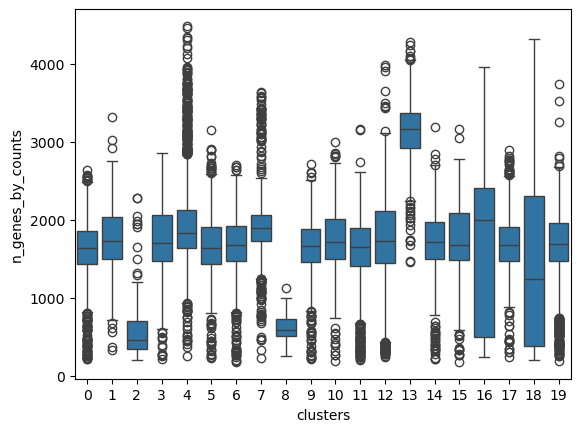

In [147]:
fig = plt.figure()
ax=sns.boxplot(adata_beta.obs, x='clusters', y='n_genes_by_counts')
fig.savefig('figures/number_genes_per_cell_by_cluster.png', dpi=300)

In [98]:
usamples = ["CG4_wt", "CG5_ob/ob", "CG10_wt", "CG11-hfd"]
lut = {usamples[i]: plt.get_cmap("tab10")(j) for i,j in enumerate([2,3,1,0])}

In [106]:
df = pd.DataFrame(columns=usamples)
for cluster in adata_beta.obs['clusters'].unique():
    count_per_cluster = adata_beta[adata_beta.obs['clusters'] == cluster].obs['sample'].value_counts()
    count_per_cluster = count_per_cluster / count_per_cluster.sum()
    df.loc[cluster] = count_per_cluster

In [109]:
df = df.fillna(0)
df = df.loc[range(20)]

Cluster 2 97.4% mapped to CG10_wt and 0% to CG4_wt  
Cluster 8 46% mapped to CG4_wt and 0% to CG10  
Cluster 13 99.2% mapped to CG10_wt and 0.3% mapped to CG4_wt  

In [143]:
outlier_clusters = [2, 8, 13]

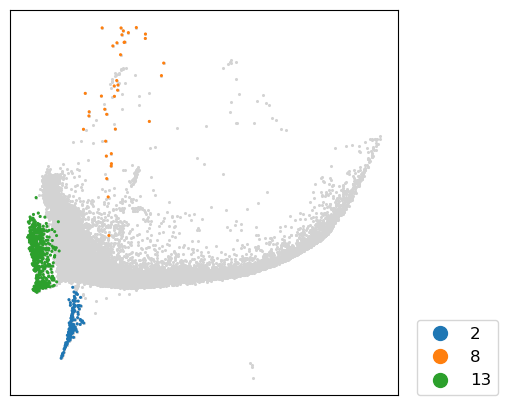

In [145]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(data_phate, c='lightgray', ax=ax)
scprep.plot.scatter2d(data_phate, c=adata_beta.obs['clusters'], ticks=None,
                      mask=adata_beta.obs['clusters'].isin(outlier_clusters), legend_loc=(1.05, 0), ax=ax)
fig.savefig('figures/outlier_beta_cells.png')

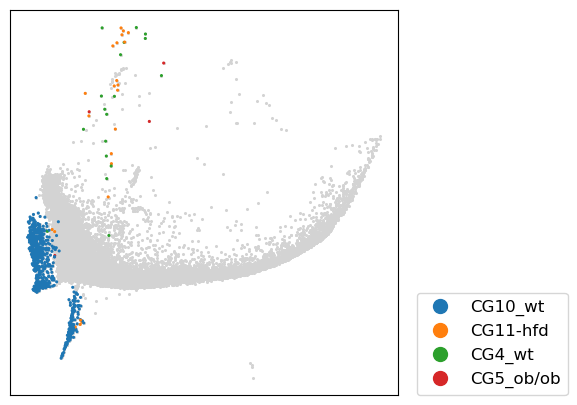

In [146]:
fig, ax = plt.subplots(figsize=(5,5))
scprep.plot.scatter2d(data_phate, c='lightgray', ax=ax)
scprep.plot.scatter2d(data_phate, c=adata_beta.obs['sample'], ticks=None,
                      mask=adata_beta.obs['clusters'].isin(outlier_clusters), legend_loc=(1.05, 0), ax=ax)
fig.savefig('figures/outlier_beta_cells_samples.png')

In [ ]:
adata_beta = adata_beta[adata_beta.obs['clusters'].isin(outlier_clusters)]

In [39]:
names = adata.obs_names.tolist() + adata_beta.obs_names.tolist()

In [38]:
adata[adata.obs_names.isin(names)].write('data/all_endocrine_processed.h5ad')

In [ ]:
del(adata_beta['clusters'])
adata_beta.write('../data/beta_run_2.h5ad')